## Import librairies

In [ ]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.load import load_classifier

from src.utils.visualize import deepCAM, plot_weighted_text

import cv2

## Import the pre-processed data

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Load a previously trained model (TFbertClassifier, ImgClassifier or TFmultiClassifier)

In [ ]:
# clf_resnet = load_classifier('image/ResNet152')
# clf_vit = load_classifier('image/vit_b16')
# clf_bert = load_classifier('text/camembert-base-ccnet')
clf_fusion = load_classifier('fusion/camembert-base-vit_b16_TF6_att12')

## Instantiating the deepCAM with the classifier

In [ ]:
icam = deepCAM(clf_fusion)

## Compute Masks for a given entry

In [8]:
#Pick some data
idx = 1
image = cv2.imread(data['img_path'][idx])
text = data['tokens'][idx]
X = {'text': text, 'image': image}

#Compute masks and maasked inputs
icam.computeMaskedInput(X, min_factor=0.0);

1/1 [==============================] - 1s 1s/step


## Plot the original inputs and the deepCAM masked inputs

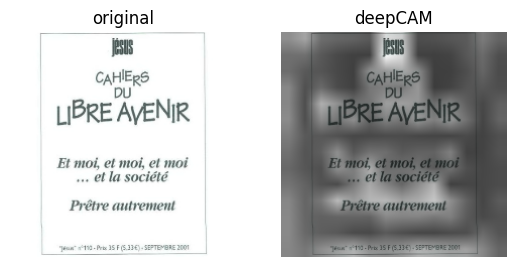

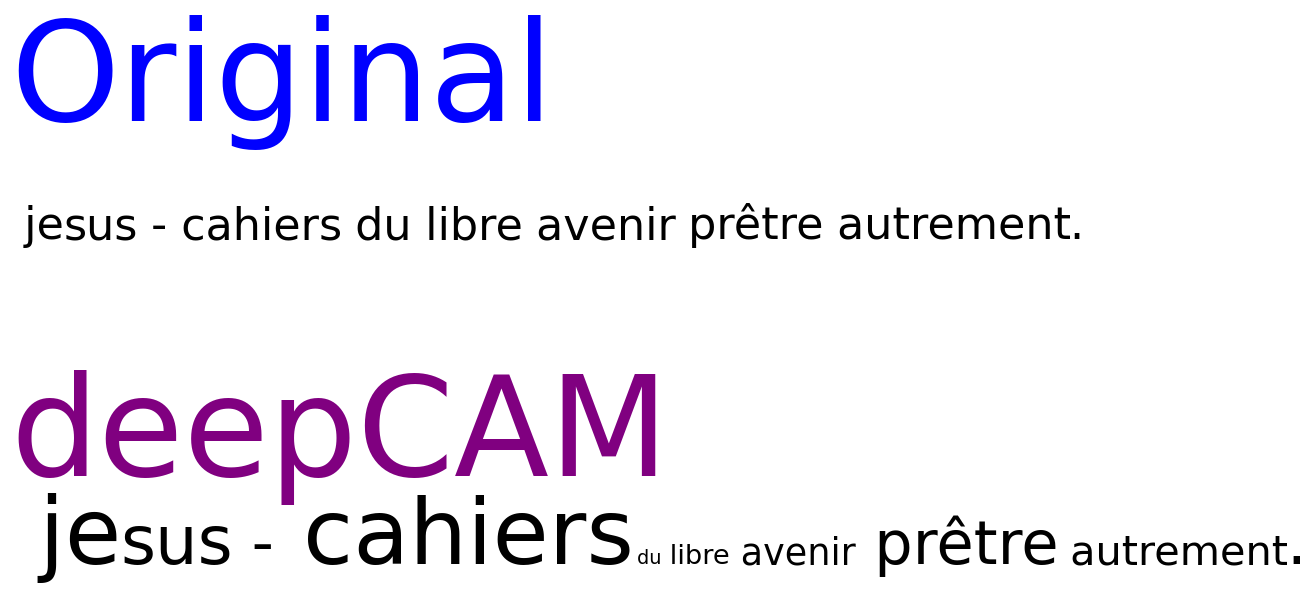

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(icam.image);
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(icam.image_masked);
ax[1].axis('off')
ax[1].set_title('deepCAM')

plt.show()

fig, ax = plt.subplots()
plot_weighted_text(0, 0.7, icam.text, icam.text_masked*0+0.4, base_font_size=80, char_per_line=80, title='Original', title_color='blue', title_fontsize=100, ax=ax)
plot_weighted_text(0, ax.get_ylim()[0], icam.text, icam.text_masked*5, base_font_size=60, char_per_line=100, title='deepCAM', title_color='purple', title_fontsize=100, ax=ax)
plt.show()